# Text Area Detection PoC (Translue)

---
<br>

**Main Idea:**<br>
Given an image, make sure that text within the image is detected. The characters themselves are not yet to be identified, just the text as such.

In [26]:
# Importing dependencies / required libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
from datetime import datetime
from Utils import *
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.models import Model
from keras.models import model_from_json

## Define the model

In [4]:
img_w = 512    # Width of image (static)
img_h = 512    # Height of image (static)
channels = 3   # Amount of color channels (Red, Green, Blue)
classes = 1    # Image classes (not necessary for us)
info = 5       # Information depth (Y is 16x16x5, so its 5)
grid_w = 16    # Image grid width
grid_h = 16    # Image grid height

In [5]:
%run -i "Preprocess.py" # Creating training input and labels

In [6]:
# Import preprocessed features and labels (X= Input to the net, Y= Ground Image Matrix)
# (X and Y numpy arrays are created with Prepocess.py <- Run this first!)
X = np.load('Data/X.npy')
Y = np.load('Data/Y.npy')

In [7]:
# We should get 461 512x512 images, each with 3 color channels (RGB)
# We measure the network by putting in the images and measuring the network output with
# 461 16x16(x1)x5 ground truth containing matrices (contains recangle info on text regions)
print(X.shape, Y.shape)

(461, 512, 512, 3) (461, 16, 16, 1, 5)


In [8]:
# Split this dataset: 75% to train the network with, 25% to measure performance
X_train, X_val, Y_train, Y_val  = train_test_split(X, Y, train_size = 0.75, shuffle = True)

In [9]:
# Defining the network model
# Input : 512,512,3 (the image's color-pixel matrix)
# Output : 16,16,1,5 (matrix containing found images)

# Store training results
def save_model(model):
    model_json = model.to_json()
    with open("model/text_detect_model.json", "w") as json_file:
        json_file.write(model_json)
 
# Load a previously trained model
def load_model(strr):        
    json_file = open(strr, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    return loaded_model
    
# This is the actual network model, based on the YOLO approach
# which we in turn based on the pre-existing MobileNetV2
def translue_model(input_shape):
    inp = Input(input_shape)
   
    # Load a library's pre-trained model as basis
    model = MobileNetV2( input_tensor=inp, include_top=False, weights='imagenet')
    last_layer = model.output
    
    # We extend ModileNetV2 by these neural layers:
    conv = Conv2D(512, (3,3), activation='relu', padding='same')(last_layer)
    conv = Dropout(0.4)(conv) # This, we need this! It's really good!
    bn = BatchNormalization()(conv)
    lr = LeakyReLU(alpha=0.1)(bn)
    
    conv = Conv2D(128, (3,3), activation='relu', padding='same')(lr)
    conv = Dropout(0.4)(conv)
    bn = BatchNormalization()(conv)
    lr = LeakyReLU(alpha=0.1)(bn)
    
    conv = Conv2D(5, (3,3), activation='tanh', padding='same')(lr)
    final = Reshape((grid_h, grid_w, classes, info))(conv)
    
    # This is the new, complete model
    model = Model(inp, final)
    
    return model

In [10]:
# Use an Adam Optimizer during training
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# Checkpoint to possibly continue with a partially trained model
checkpoint = ModelCheckpoint('model/text_detect.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min', period=1)

In [11]:
# Define the cost function
# Network's y_true dim:      16,16,1,5
# Ground Truth's y_pred dim: 16,16,1,5

def loss_func(y_true, y_pred):
    l_coords = 5.0
    l_noob = 0.5
    coords = y_true[:,:,:,:,0] * l_coords
    noobs = (-1 * (y_true[:,:,:,:,0] - 1) * l_noob)
    p_pred = y_pred[:,:,:,:,0]
    p_true = y_true[:,:,:,:,0]
    x_true = y_true[:,:,:,:,1]
    x_pred = y_pred[:,:,:,:,1]
    yy_true = y_true[:,:,:,:,2]
    yy_pred = y_pred[:,:,:,:,2]
    w_true = y_true[:,:,:,:,3]
    w_pred = y_pred[:,:,:,:,3]
    h_true = y_true[:,:,:,:,4]
    h_pred = y_pred[:,:,:,:,4]
    
    p_loss_absent = K.sum(K.square(p_pred - p_true) * noobs)
    p_loss_present = K.sum(K.square(p_pred - p_true))
    x_loss = K.sum(K.square(x_pred - x_true) * coords)
    yy_loss = K.sum(K.square(yy_pred - yy_true) * coords)
    xy_loss = x_loss + yy_loss
    w_loss = K.sum(K.square(K.sqrt(w_pred) - K.sqrt(w_true)) * coords)
    h_loss = K.sum(K.square(K.sqrt(h_pred) - K.sqrt(h_true)) * coords)
    wh_loss = w_loss + h_loss
    
    loss = p_loss_absent + p_loss_present + xy_loss + wh_loss
    
    return loss

In [12]:
# Load and save model
input_size = (img_h, img_w, channels)

model = translue_model(input_size)
print(model.summary())

save_model(model)

2022-09-30 23:46:05.071913: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-30 23:46:05.072390: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-30 23:46:05.074995: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 256, 256, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 256, 256, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 256, 256, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

Total params: 8,755,013
Trainable params: 8,719,621
Non-trainable params: 35,392
__________________________________________________________________________________________________
None


## Training the model (Caution)

In [18]:
# Load pre-trained weights (from previous training iterations)
model.load_weights('model/text_detect.h5')

In [19]:
model.compile(loss=loss_func, optimizer=opt, metrics = ['accuracy'])

In [20]:
# [!] CAUTION - This trains the model 30x on 4 random images
# Uncomment below only if you have time and a powerful machine
# Below approach is outdated now, but it shows the idea of what's happening
hist = model.fit(X_train, Y_train, epochs= 1, batch_size = 4, callbacks=[checkpoint], validation_data=(X_val, Y_val))

4/4 [==============================] - 102s 27s/step - loss: 1.5104 - accuracy: 0.0462 - val_loss: 23.9728 - val_accuracy: 0.0460


In [21]:
# After training: Save training progress on the model
model.save_weights('model/text_detect.h5')

## Evaluate the model

In [22]:
# Load the most recent model from files
model = load_model('model/text_detect_model.json')
model.load_weights('model/text_detect.h5')

In [23]:
def predict_func(model, inp, iou, name):

    ans = model.predict(inp)
    boxes = decode(ans[0], img_w, img_h, iou)
    img = ((inp + 1) / 2)
    img = img[0]

    # Draw boxes by their coordinates
    for i in boxes:
        i = [int(x) for x in i]
        img = cv2.rectangle(img, (i[0], i[1]), (i[2], i[3]), color = (0,255,0), thickness = 2)

    plt.imshow(img)
    plt.show()
    
    cv2.imwrite(os.path.join('Results', str(name) + '.jpg'), img * 255.0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


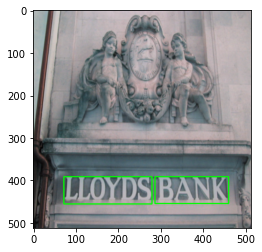

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


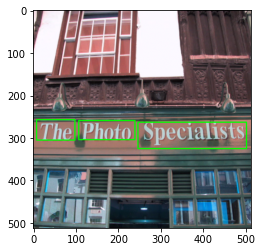

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


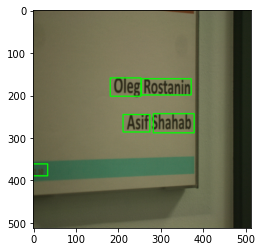

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


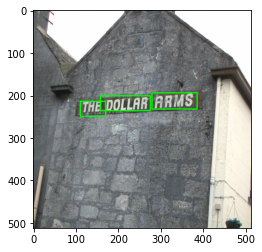

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


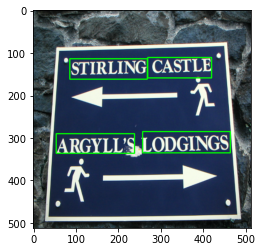

In [29]:
rand = np.random.randint(0, X_val.shape[0], size = 5)

for i in rand:
    predict_func(model, X_val[i:i+1], 0.5, i)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


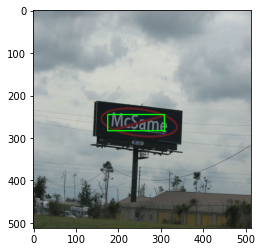

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


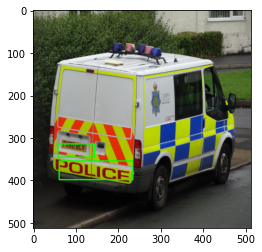

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


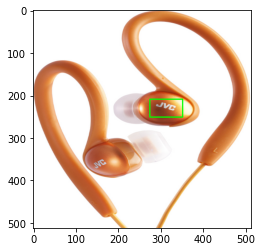

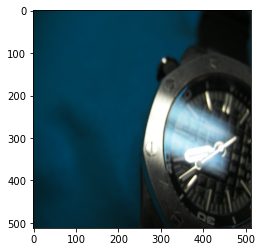

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


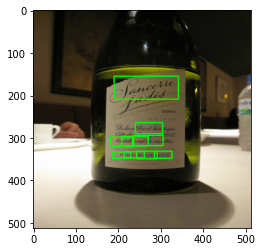

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


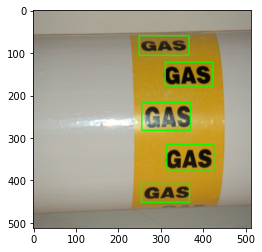

In [25]:
# Solely predict on entirely new, unseen data (from the Test directory)
for i in os.listdir('Test'):
    img = cv2.cvtColor(cv2.imread(os.path.join('Test', i)), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(512,512))
    img = (img - 127.5)/127.5
    predict_func(model, np.expand_dims(img, axis= 0), 0.5, f'sample - {i}')